# Exploration of Zipf's Law and Informal Communication with Twitter Sentiments

Data from: **https://www.kaggle.com/datasets/saurabhshahane/twitter-sentiment-dataset/data**

This project delves into informal communication on Twitter/X to explore the application of Zipf's Law of Abbreviation within the context of sentiments. The primary goal is to investigate whether this law extends to the condensed and informal nature of tweets. Beyond this inquiry, the exploration aims to discern the influence of sentiments (positive, neutral, and negative) on the adherence to Zipf's Law. The hypothesis suggests that all sentiments will conform to Zipf's Law without significant disparities.


The structure of this code will be in the form of:

1. Loading data and EDA
2. Preprocessing Data
3. Sentiment Analysis
4. Visualizations
5. Zipf's Law
6. ANOVA
7. Conclusion

### Importing data and EDA

In [1]:
import altair as alt
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import re 
from sklearn.feature_extraction.text import CountVectorizer
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from scipy.stats import chisquare
from scipy.stats import f_oneway
import vegafusion as vf
import vega

In [2]:
# Uncomment if package is not yet installed or out of date
# nltk.download('stopwords') 

In [3]:
# Load dataset 
df = pd.read_csv('data/Twitter_Data.csv')

df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [4]:
print(df.columns)
print(df.shape)

Index(['clean_text', 'category'], dtype='object')
(162980, 2)


In [5]:
# Review data type
print(df['clean_text'].dtype)

object


In [6]:
# Rename the 'clean_text' column to 'text'
df.rename(columns={'clean_text': 'text'}, inplace=True)

# Change data type
df['text'] = df['text'].astype(str)

# Drop any missing instances
df.dropna(subset=['text', 'category'], inplace=True)

print(df.shape)

(162973, 2)


### Data preprocessing

In [7]:
# Preprocess text
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|\#\w+', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenization and removal of stop words
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    
    # Token to string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

In [8]:
# Preprocessing to the 'text' column
df['preprocessed_text'] = df['text'].apply(preprocess_text)

print(df[['text', 'preprocessed_text']].head())

                                                text  \
0  when modi promised “minimum government maximum...   
1  talk all the nonsense and continue all the dra...   
2  what did just say vote for modi  welcome bjp t...   
3  asking his supporters prefix chowkidar their n...   
4  answer who among these the most powerful world...   

                                   preprocessed_text  
0  modi promised “ minimum government maximum gov...  
1             talk nonsense continue drama vote modi  
2  say vote modi welcome bjp told rahul main camp...  
3  asking supporters prefix chowkidar names modi ...  
4  answer among powerful world leader today trump...  


In [9]:
df.head()

,text,category,preprocessed_text
0,when modi promised “minimum government maximum...,-1.0,modi promised “ minimum government maximum gov...
1,talk all the nonsense and continue all the dra...,0.0,talk nonsense continue drama vote modi
2,what did just say vote for modi welcome bjp t...,1.0,say vote modi welcome bjp told rahul main camp...
3,asking his supporters prefix chowkidar their n...,1.0,asking supporters prefix chowkidar names modi ...
4,answer who among these the most powerful world...,1.0,answer among powerful world leader today trump...


### Sentiment Analysis

In [10]:
X = df['text']
y = df['category']

# Drop rows with missing values in the 'category' column
df.dropna(subset=['category'], inplace=True)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000) 
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Logistic Regression model
model = LogisticRegression(random_state=42)
model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = model.predict(X_test_tfidf)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.92
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.91      0.82      0.87      7230
         0.0       0.92      0.98      0.95     10961
         1.0       0.94      0.93      0.93     14404

    accuracy                           0.92     32595
   macro avg       0.92      0.91      0.92     32595
weighted avg       0.92      0.92      0.92     32595



/Users/darwin/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We do have 162973 rows, which is more than my machine can handle. To address this limitation I took in account of oversampling and also the Central Limit Theorem, where if the data is large enough, it will always converge to the correct correlated value. In this case I have decided to scale the data to help with optimization (https://scikit-learn.org/stable/modules/preprocessing.html). 

In [11]:
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_tfidf)
X_test_scaled = scaler.transform(X_test_tfidf)

model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [12]:
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.90      0.86      0.88      7230
         0.0       0.94      0.97      0.95     10961
         1.0       0.94      0.94      0.94     14404

    accuracy                           0.93     32595
   macro avg       0.93      0.92      0.93     32595
weighted avg       0.93      0.93      0.93     32595



### Visualizations

In [13]:
alt.data_transformers.enable("vegafusion")
df['word_length'] = df['preprocessed_text'].apply(lambda x: len(x.split()))

charts = []
for category_value in df['category'].unique():
    category_data = df[df['category'] == category_value]
    color = 'forestgreen' if category_value == 1 else 'cornflowerblue' if category_value == 0 else 'indianred'    
    chart = alt.Chart(category_data).mark_bar().encode(
        alt.X('word_length:O', title='Word Length'),
        alt.Y('count():Q', title='Frequency'),
        color=alt.value(color),  
    ).properties(
        title=f'Distribution of Word Lengths - Category {category_value}',
        width=800,
        height=150,
    )
    charts.append(chart)

concatenated_chart = alt.vconcat(*charts)

concatenated_chart

alt.VConcatChart(...)

### Zipf's Law

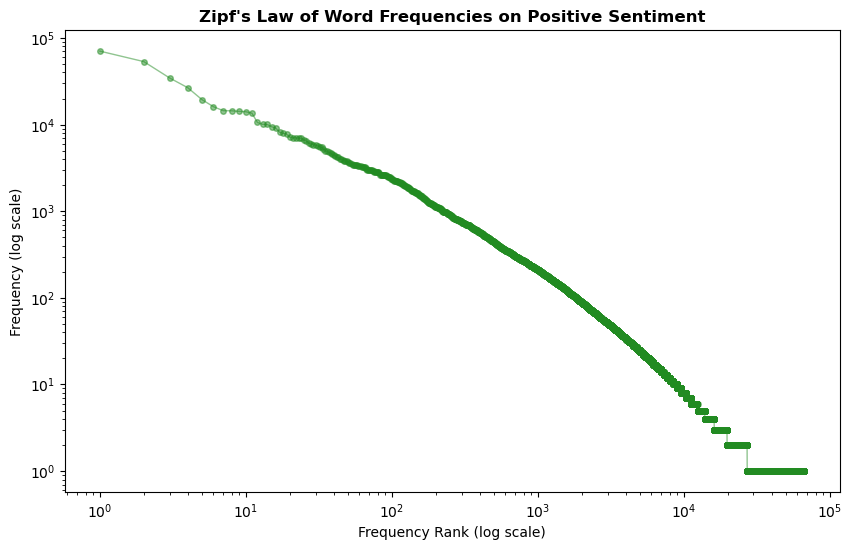

In [14]:
# Filter positive sentiment data
df_positive = df[df['category'] == 1]
positive_text = df_positive['text']

# Use CountVectorizer to calculate word frequencies
vectorizer_positive = CountVectorizer()
word_frequencies_positive = vectorizer_positive.fit_transform(positive_text)

# Get feature names (words) and their frequencies
word_names_positive = vectorizer_positive.get_feature_names_out()
word_counts_positive = np.asarray(word_frequencies_positive.sum(axis=0))[0]

# Create a DataFrame to store word frequencies
word_freq_df_positive = pd.DataFrame({'word': word_names_positive, 'count': word_counts_positive})

# Sort the DataFrame by word frequency in descending order
word_freq_df_positive = word_freq_df_positive.sort_values(by='count', ascending=False)

# Create log transformed plot for positive sentiment 
plt.figure(figsize=(10, 6))
plt.loglog(range(1, len(word_freq_df_positive) + 1), word_freq_df_positive['count'], marker='o', linestyle='-', color='forestgreen', alpha=0.5, markersize=4, linewidth=1)
plt.title('Zipf\'s Law of Word Frequencies on Positive Sentiment', fontweight='bold')
plt.xlabel('Frequency Rank (log scale)')
plt.ylabel('Frequency (log scale)')
plt.show()

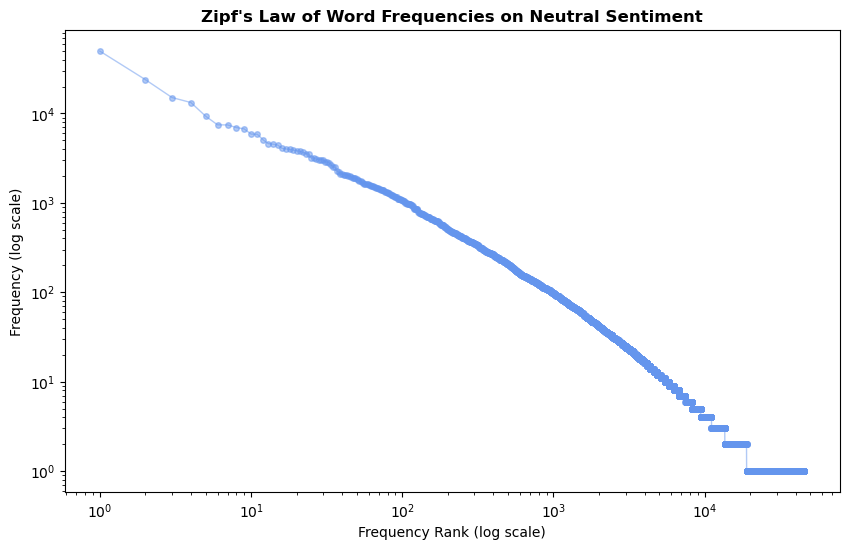

In [15]:
# Filter neutral sentiment data
df_neutral = df[df['category'] == 0]
neutral_text = df_neutral['text']

# Use CountVectorizer to calculate word frequencies
vectorizer_neutral = CountVectorizer()
word_frequencies_neutral = vectorizer_neutral.fit_transform(neutral_text)

# Get feature names (words) and their frequencies
word_names_neutral = vectorizer_neutral.get_feature_names_out()
word_counts_neutral = np.asarray(word_frequencies_neutral.sum(axis=0))[0]

# Create a DataFrame to store word frequencies
word_freq_df_neutral = pd.DataFrame({'word': word_names_neutral, 'count': word_counts_neutral})

# Sort the DataFrame by word frequency in descending order
word_freq_df_neutral = word_freq_df_neutral.sort_values(by='count', ascending=False)

# Create log transformed plot for neutral sentiment 
plt.figure(figsize=(10, 6))
plt.loglog(range(1, len(word_freq_df_neutral) + 1), word_freq_df_neutral['count'], marker='o', linestyle='-', color='cornflowerblue', alpha=0.5, markersize=4, linewidth=1)
plt.title('Zipf\'s Law of Word Frequencies on Neutral Sentiment', fontweight='bold')
plt.xlabel('Frequency Rank (log scale)')
plt.ylabel('Frequency (log scale)')
plt.show()

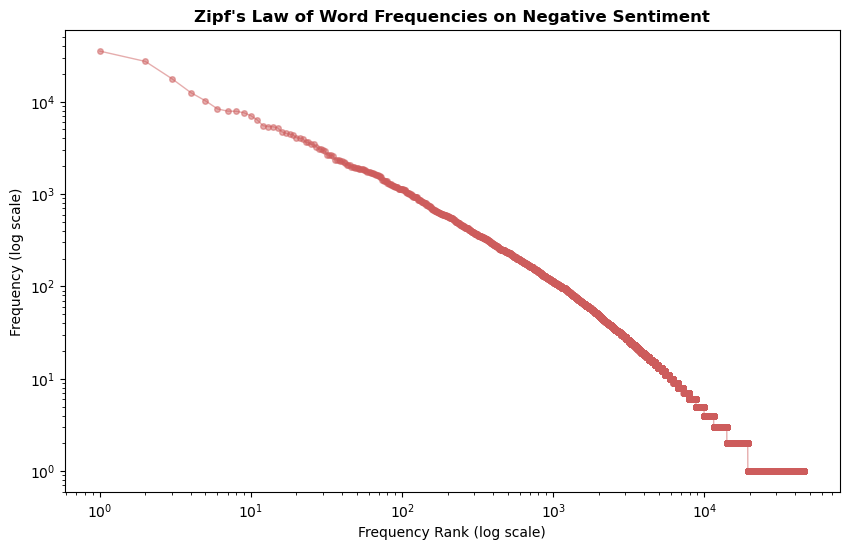

In [16]:
# Filter negative sentiment data
df_negative = df[df['category'] == -1]
negative_text = df_negative['text']

# Use CountVectorizer to calculate word frequencies
vectorizer_negative = CountVectorizer()
word_frequencies_negative = vectorizer_negative.fit_transform(negative_text)

# Get feature names (words) and their frequencies
word_names_negative = vectorizer_negative.get_feature_names_out()
word_counts_negative = np.asarray(word_frequencies_negative.sum(axis=0))[0]

# Create a DataFrame to store word frequencies
word_freq_df_negative = pd.DataFrame({'word': word_names_negative, 'count': word_counts_negative})

# Sort the DataFrame by word frequency in descending order
word_freq_df_negative = word_freq_df_negative.sort_values(by='count', ascending=False)

# Create log transformed plot for negative sentiment 
plt.figure(figsize=(10, 6))
plt.loglog(range(1, len(word_freq_df_negative) + 1), word_freq_df_negative['count'], marker='o', linestyle='-', color='indianred', alpha=0.5, markersize=4, linewidth=1)
plt.title('Zipf\'s Law of Word Frequencies on Negative Sentiment', fontweight='bold')
plt.xlabel('Frequency Rank (log scale)')
plt.ylabel('Frequency (log scale)')
plt.show()

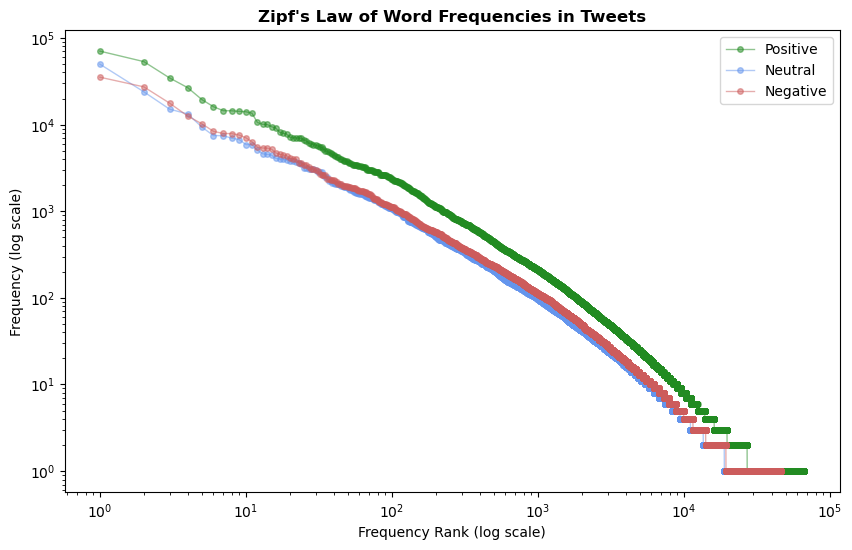

In [17]:
plt.figure(figsize=(10, 6))

# Positive sentiment
plt.loglog(range(1, len(word_freq_df_positive) + 1), word_freq_df_positive['count'], marker='o', linestyle='-', color='forestgreen', alpha=0.5, markersize=4, linewidth=1, label='Positive')

# Neutral sentiment
plt.loglog(range(1, len(word_freq_df_neutral) + 1), word_freq_df_neutral['count'], marker='o', linestyle='-', color='cornflowerblue', alpha=0.5, markersize=4, linewidth=1, label='Neutral')

# Negative sentiment
plt.loglog(range(1, len(word_freq_df_negative) + 1), word_freq_df_negative['count'], marker='o', linestyle='-', color='indianred', alpha=0.5, markersize=4, linewidth=1, label='Negative')

plt.title('Zipf\'s Law of Word Frequencies in Tweets', fontweight='bold')
plt.xlabel('Frequency Rank (log scale)')
plt.ylabel('Frequency (log scale)')
plt.legend()
plt.show()

### ANOVA

Performing one way ANOVA

Null hypotehsis: There are no signficinat differences between the means of the group. 

In [18]:
word_freq_positive = word_freq_df_positive['count']
word_freq_neutral = word_freq_df_neutral['count']
word_freq_negative = word_freq_df_negative['count']

# ANOVA test
statistic, p_value = f_oneway(word_freq_positive, word_freq_neutral, word_freq_negative)

print(f'ANOVA Statistic: {statistic}')
print(f'P-value: {p_value}')

# Check for significance
alpha = 0.05
if p_value < alpha:
    print('The differences between at least two groups are statistically significant.')
else:
    print('There is not enough evidence to suggest significant differences between groups.')

ANOVA Statistic: 6.219432326698372
P-value: 0.0019908599382104757
The differences between at least two groups are statistically significant.


In [19]:
word_freq_all = np.concatenate([word_freq_positive, word_freq_neutral, word_freq_negative])

# Corresponding group array
groups = ['Positive'] * len(word_freq_positive) + ['Neutral'] * len(word_freq_neutral) + ['Negative'] * len(word_freq_negative)

# Tukey's HSD test
tukey_results = pairwise_tukeyhsd(word_freq_all, groups)

print(tukey_results)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
Negative  Neutral  -1.1846 0.8787 -6.9153  4.5461  False
Negative Positive    5.984 0.0207   0.731 11.2371   True
 Neutral Positive   7.1686 0.0041  1.9029 12.4344   True
--------------------------------------------------------


**Negative vs. Neutral:**
Mean Difference (meandiff): -1.1846
p-adj (Adjusted p-value): 0.8787

    Conclusion: There is no significant difference in word length between the Negative and Neutral groups (reject = False).




**Negative vs. Positive:**
Mean Difference (meandiff): 5.984
p-adj (Adjusted p-value): 0.0207

    Conclusion: There is a significant difference in word length between the Negative and Positive groups (reject = True).




**Neutral vs. Positive:**
Mean Difference (meandiff): 7.1686
p-adj (Adjusted p-value): 0.0041

    Conclusion: There is a significant difference in word length between the Neutral and Positive groups (reject = True).




Negative and Neutral groups do not have a significant difference in word length.
Both Negative vs. Positive and Neutral vs. Positive comparisons show a significant difference in word length, with the Positive group having longer words on average.

### Conclusion

In this study, we delved into the intricacies of sentiment analysis within the realm of informal language on Twitter/X, aiming to discern the applicability of Zipf's law to the distribution of word frequencies. The sentiment analysis model demonstrated a strong performance with an accuracy of 93%, shedding light on the informal nature of communication on this platform. Our ANOVA and Tukey's HSD post hoc tests explored word length disparities among sentiment groups, revealing that, while negative and neutral sentiments share similar word lengths, positive sentiments tend to feature significantly longer words. Additionally, our investigation into Zipf's law uncovered notable adherence in the word frequency distributions, further supporting Zipf's Law in informal language as observed on Twitter/X. These findings contribute to a deeper understanding of communicative efficiency in informal discourse, offering valuable insights for natural language processing applications. While there are certain limitations, such as the use of recent data about the Indian election, future iterations could involve different datasets, refined models, and analysis using various machine learning models.